In [20]:
import main_funs
import pandas as pd
import numpy as np 
import rioxarray as rxr
import matplotlib.pylab as plt 

# Canopy nitrogen mapping
Welcome! 

The goal of this script is to estimate plant nitrogen content using hyerspectral remote sensing and machine learning. The data are collected in 2015 from Idaho and California. In this script we just used a subset of the data since the main goal is to demonstrate the application of machine learning techniques in remote sensing of canopy chemistry. 

The steps are:
1. Download two data file
    * A CSV file containing the measured nitrogen content for 195 plot and associated hyperspectral signature from AVIRIS-NG airborne remote sensing sensor. We use this file for training our model. 
    * A hyperspectral image to apply the trained model on it and produce nitrogen map for a small region. 
2. Clean the training data
    * Remove bad spectral bands (including negative reflectance) 
    * Remove portion of spectra related to water absorption bands. 
3. Train the model using partial least square regression. 
4. Prepare the hyperspectral image and make it consistent with the training data. 
5. Apply the trained 
model on the image and create the nitrogen map. 
6. Create the report.

In [21]:
# Download the CSV and hyperspectral image files and save them in ./data/raw 
# directory. 

# url_tif = "https://drive.google.com/uc?id=1UOEeyzHW-h0el2Qzk1o7BiSsqT8f8ax2"
# url_tfw = "https://drive.google.com/uc?id=1I3Ns7sQ4ETFVsYD6sEQXzR65xHtyFIfD"
# main_funs.gdown_file(url_tif, "./data/raw/hyper_image.tif")
# main_funs.gdown_file(url_tfw, "./data/raw/hyper_image.tfw")

data = pd.read_csv("./data/raw/Data.csv")
print("--------------------------------\n")
print("The CSV file includes\n")
print(data)
print((f"\n\nNumber of observations {data.shape[0]-1}"
f" and {data.shape[1]-1} spectral bands."))


--------------------------------

The CSV file includes

     nitrogen  381.36026  386.368927  391.377594  396.386292  401.394958  \
0         NaN  -0.015750   -0.000410    0.002750    0.010720    0.010480   
1         NaN  -0.025010   -0.011980   -0.010180   -0.003490   -0.003820   
2         NaN  -0.010730    0.008020    0.011260    0.020860    0.021050   
3         NaN  -0.008530    0.008100    0.010440    0.018360    0.016780   
4    1.223945  -0.020460   -0.005830   -0.002950    0.004900    0.004650   
..        ...        ...         ...         ...         ...         ...   
191  2.166600   0.005535    0.052470    0.058871    0.070103    0.072897   
192  2.408300   0.003750    0.047256    0.053006    0.063522    0.065950   
193  2.600000   0.007845    0.058672    0.063979    0.076104    0.079309   
194       NaN   0.007469    0.057818    0.064453    0.075616    0.079102   
195  2.400000   0.005595    0.053338    0.058369    0.069548    0.072299   

     406.403625  411.412292  4

In [22]:
# -------- Data cleaning -----------------
# Remove samples with no N measurments
data = data[~np.isnan(data["nitrogen"])]
# Select bands that there is no nan in spectral measurments
y = data["nitrogen"].values
spec = data.iloc[:, 1:]
spec = spec[spec > 0]
not_nan = np.where(~np.any(np.isnan(spec), axis=0))[0]
spec = spec.iloc[:, not_nan]


In [23]:
# Remove the water absorption bands
wl = np.array(spec.columns.values)
f = np.vectorize(float)
wl = f(wl)
water_abs1 = np.where((wl >= 1300) & (wl <= 1450))
water_abs2 = np.where((wl >= 1750) & (wl <= 2000))
bad_bands = np.concatenate((water_abs1, water_abs2), axis=1)[0]
wl = np.delete(wl, bad_bands, 0)
X = np.delete(spec.values, bad_bands, 1)

In [25]:

pls_opt, I, y_c, y_cv, score_c, score_cv, mse_c, mse_cv = main_funs.plsr(X, y, 15)
print(pls_opt)


PLSRegression(n_components=15)


In [26]:
img = rxr.open_rasterio("./data/raw/hyper_image.tif")
# img = rxr.open_rasterio(in_dir + "hyper_flightline.tif")
img["band"] = img["band"] - 1
img = img.isel(band=not_nan)
img = img.drop(bad_bands, dim="band")
img = img.isel(band=np.squeeze(I))
# img = img.chunk(chunks={'x': 100, 'y': 200})
print(img)

<xarray.DataArray (band: 51, y: 559, x: 572)>
[16307148 values with dtype=float32]
Coordinates:
  * band         (band) int64 8 13 17 18 22 29 77 ... 359 363 367 368 371 372
  * x            (x) float64 3.939e+05 3.939e+05 ... 3.945e+05 3.945e+05
  * y            (y) float64 4.05e+06 4.05e+06 4.05e+06 ... 4.05e+06 4.05e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [28]:
nitrogen_map = main_funs.predict(img, pls_opt, "band")

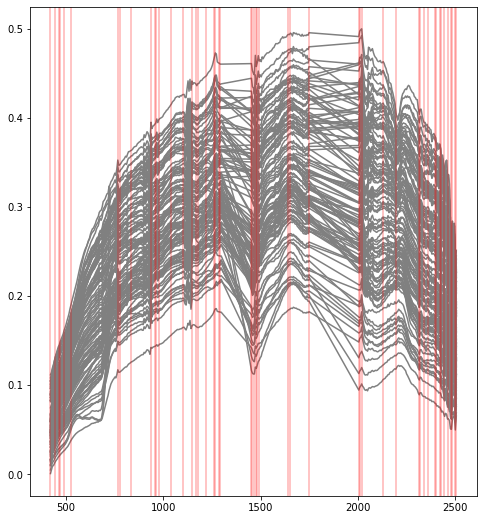

In [29]:
plt.close()
fig, ax = plt.subplots(figsize=(8, 9))
ax.plot(wl, X.T, color="gray")
[
    plt.axvline(x=wl[i], color='r', alpha=0.3, label='axvline - full height')
    for i in I
]
plt.savefig("./reports/figures/selected_bands.png")

In [ ]:
plt.close()
nitrogen_map.plot.imshow()
plt.savefig("./reports/figures/nitrogen_map.png")